# Free Pass Data Science BCC 2021
Percobaan Ketiga (Percobaan pertama dan kedua gagal)

Sulthan Abiyyu Hakim | 12 November 2021

-----

## Deskripsi File

### Penjelasan atribut dan kelas target
- id - Id unik setiap review
- review - Review yang diberikan pengguna
- jenis_review - Jenis dari review (0=review buruk, 1=review baik)

### Perbaikan dari percobaan sebelumnya
1. Coba split data untuk holdout, sementara data training untuk cross validation
2. Coba menggunakan GridSearchCV untuk mencari parameter optimal dari model Logistic Regression
3. Coba melakukan evaluasi dengan menggunakan confusion matrix, f1 score, ROC curve, AUC curve, dan precision recall curve (untuk belajar)
4. Mencoba membuat 2 dataframe dengan sample yang imbalance dan undersample


In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_utama = pd.read_csv('data/train.csv')
df_utama.head()

,id,review,jenis_review
0,mnac5vg0i3mp5bdp,proses check-in kalau bisa lebih dipercepat ke...,0
1,1y7m90hp3wwok7fm,"Kamar ga sesuai , ada bekas bocor dilangit2 , ...",0
2,suvdvwh580hmj8nz,Wifi nya aktif tapi tidak bisa di pakai...lele...,1
3,t07ma1ie3w29kqzy,"breakfast harus selalu dikontrol, jangan sampa...",0
4,jcwq3gfdryrdbdx5,"pelayanan ramah namun... tidak ada colokan, ai...",0


## Data Prepocessing

In [113]:
# Checking for missing values
df_utama.isnull().sum()

id              0
review          0
jenis_review    0
dtype: int64

In [114]:
# Checking for duplicate values
df_utama.duplicated().sum()

0

In [115]:
# Checking for unique values
df_utama.nunique()

id              11142
review          11142
jenis_review        2
dtype: int64

In [116]:
# Checking data types
df_utama.dtypes

id              object
review          object
jenis_review     int64
dtype: object

In [117]:
# Overall information
df_utama.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11142 entries, 0 to 11141
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            11142 non-null  object
 1   review        11142 non-null  object
 2   jenis_review  11142 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 261.3+ KB


### Kesimpulan Data Prepocessing
Tidak terdapat missing value, duplicates, dan data type yang salah
Sebenarnya banyak data cleaning yang bisa dilakukan terutama pada kolom review, tapi pada saat ini saya masih belum belajar sampai situ.


-----------

## Modeling
Karena ini adalah kasus binary classification, maka kali ini akan menggunakan model Logistic Regression.

In [42]:
# Splitting data
X_normal = df_utama.drop(columns=["jenis_review", "id"])
y_normal = df_utama["jenis_review"]

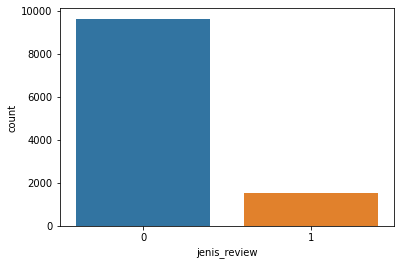

In [43]:
# data normal tanpa sampling

sns.countplot(x=y_normal)
plt.show()

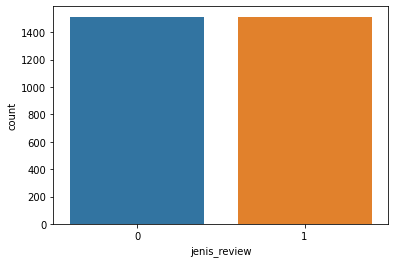

In [44]:
# Undersampling with random sampling
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0, sampling_strategy='majority')

X_under, y_under = rus.fit_resample(X_normal, y_normal)
sns.countplot(x=y_under)
plt.show()

In [45]:
# Vectorizing data with TF IDF
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X_tf_under = vectorizer.fit_transform(X_under.values.ravel())
X_tf_normal = vectorizer.transform(X_normal.values.ravel())
X_tf_normal.shape

(11142, 5439)

In [46]:
# Check if the column's size is the same
X_tf_under.shape

(3026, 5439)

In [47]:
# Splitting into holdout
from sklearn.model_selection import train_test_split

X_train_normal, X_test_normal, y_train_normal, y_test_normal = train_test_split(
    X_tf_normal, 
    y_normal, 
    test_size=0.2, 
    random_state=0
    )

X_train_under, X_test_under , y_train_under, y_test_under = train_test_split(
    X_tf_under, 
    y_under, 
    test_size=0.2, 
    random_state=0)

In [99]:
# Make a logistic regression model and gridsearchcv
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from warnings import filterwarnings

# Ignoring warnings
filterwarnings('ignore')

logreg = LogisticRegression()
c_space = np.logspace(-5, 8, 15)
params = {
    'C': c_space,
}

gridReg_normal = GridSearchCV(logreg, params, cv=10, scoring="f1")
gridReg_under = GridSearchCV(logreg, params, cv=10, scoring="f1")

gridReg_normal.fit(X_train_normal, y_train_normal)
gridReg_under.fit(X_train_under, y_train_under)

print(f"Best F1-Score Normal Sample : {gridReg_normal.best_score_}")
print(f"Best C-Value Normal Sample  : {gridReg_normal.best_params_}")

print(f"Best F1-Score Under Sample : {gridReg_under.best_score_}")
print(f"Best C-Value Under Sample  : {gridReg_under.best_params_}")

Best F1-Score Normal Sample : 0.741417494365934
Best C-Value Normal Sample  : {'C': 3.727593720314938}
Best F1-Score Under Sample : 0.8774403195847101
Best C-Value Under Sample  : {'C': 3.727593720314938}


## Evaluasi Model
Proses evaluasi dengan menggunakan test set

In [100]:
# Predicting with testing set
y_pred_normal = gridReg_normal.predict(X_test_normal)
y_pred_under = gridReg_under.predict(X_test_under)

In [101]:
# Scoring with f1 score
from sklearn.metrics import f1_score
print(f"F1-Score Normal Sample : {f1_score(y_test_normal, y_pred_normal)}")
print(f"FI-Score Under Sample  : {f1_score(y_test_under, y_pred_under)}")

F1-Score Normal Sample : 0.7773972602739726
FI-Score Under Sample  : 0.8896925858951176


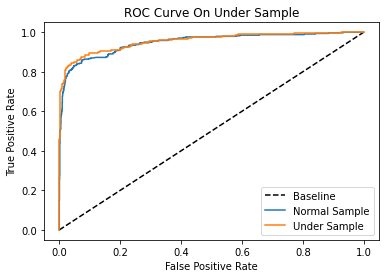

In [102]:
# Scoring with ROC curve
from sklearn.metrics import roc_curve

y_pred_normal_prob = gridReg_normal.predict_proba(X_test_normal)[:, 1]
y_pred_under_prob = gridReg_under.predict_proba(X_test_under)[:, 1]

fpr_normal, tpr_normal, thesholds_normal = roc_curve(y_test_normal, y_pred_normal_prob)
fpr_under, tpr_under, thesholds_under = roc_curve(y_test_under, y_pred_under_prob)

# Plotting ROC curve on normal sample
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_normal, tpr_normal)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve On Normal Sample')


# Plotting ROC curve on under sample
plt.plot(fpr_under, tpr_under)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve On Under Sample')
plt.legend(["Baseline","Normal Sample" ,"Under Sample"])
plt.show()

In [103]:
# Scoring with AUC score
from sklearn.metrics import roc_auc_score

print(f"Normal sample AUC score : {roc_auc_score(y_test_normal, y_pred_normal_prob)}")
print(f"Under sample AUC score  : {roc_auc_score(y_test_under, y_pred_under_prob)}")

Normal sample AUC score : 0.9491534174648522
Under sample AUC score  : 0.9557842868874898


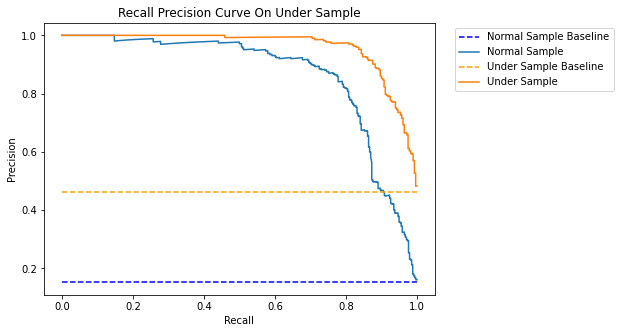

In [104]:
# Scoring with recall precision curve
from sklearn.metrics import precision_recall_curve

precision_normal, recall_normal, thresholds_normal = precision_recall_curve(y_test_normal, y_pred_normal_prob)
precision_under, recall_under, thresholds_under = precision_recall_curve(y_test_under, y_pred_under_prob)

# Figure size
plt.figure(figsize=(7, 5))

# Plotting recall precision curve on normal sample
baseline_normal = len(y_test_normal[y_test_normal == 1]) / len(y_test_normal)
plt.plot([0, 1], [baseline_normal, baseline_normal], 'k--', color='blue')
plt.plot(recall_normal, precision_normal)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Recall Precision Curve On Normal Sample')

# Plotting recall precision curve on under sample
baseline_under = len(y_test_under[y_test_under == 1]) / len(y_test_under)
plt.plot([0, 1], [baseline_under, baseline_under], 'k--', color="orange")
plt.plot(recall_under, precision_under)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Recall Precision Curve On Under Sample')
plt.legend([
    "Normal Sample Baseline", "Normal Sample", "Under Sample Baseline",
    "Under Sample"
], bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()


### Kesimpulan Modeling

Dengan menggunakan logistic regression, hasil score tertinggi adalah ketika data dilakukan proses under sampling. Tapi hal tersebut belum bisa menjadi acuan apakah model ML sudah reliable atau belum. Konteks yang harus diingat adalah dataset diperoleh dari suatu hotel yang memiliki reputasi buruk. Sehingga review negatif tentunya lebih banyak dibandingkan dengan review positif. Jadi, untuk melakukan prediksi selanjutnya akan tetap menggunakan kedua model yang belum dan sudah di sampling.

------

## Prediksi test dataset untuk submission

In [105]:
test_df = pd.read_csv("data/test.csv")
test_df.head()

,id,review
0,263aqhh4ymyaubmb,tv nya rusak.....kamar mandi kurang bersih...
1,36frqq1ne0ljsgtj,SO BAD REALLY BAD VERY BAD BAD AND BAD RECEPTI...
2,4dbq2twnu8nd9ztm,"SANGAT MENGECEWAKAN. SAAT MASUK KAMAR, LANTAI ..."
3,hbsb134diyefkd3i,Shower tidak berfungsi
4,o068bc8hfiisuwon,privasi sangat minim karena suara kamar tetang...


In [107]:
X_test_final = vectorizer.transform(test_df["review"].values.ravel())
X_test_final.shape

(3714, 5439)

In [108]:
y_pred_final_normal = gridReg_normal.predict(X_test_final)
y_pred_final_under = gridReg_under.predict(X_test_final)

test_df["pred_normal"] = y_pred_final_normal
test_df["pred_under"] = y_pred_final_under
test_df.head()

,id,review,pred_normal,pred_under
0,263aqhh4ymyaubmb,tv nya rusak.....kamar mandi kurang bersih...,0,0
1,36frqq1ne0ljsgtj,SO BAD REALLY BAD VERY BAD BAD AND BAD RECEPTI...,0,0
2,4dbq2twnu8nd9ztm,"SANGAT MENGECEWAKAN. SAAT MASUK KAMAR, LANTAI ...",0,0
3,hbsb134diyefkd3i,Shower tidak berfungsi,0,0
4,o068bc8hfiisuwon,privasi sangat minim karena suara kamar tetang...,0,0


In [110]:
# Saving the predictions to csv
test_df.to_csv("percobaan3/predictions.csv", index=False)

In [111]:
# Saving the predictions to excel
test_df.to_excel("percobaan3/predictions.xlsx", index=False)

## Penutupan
Setelah melakukan pencocokan secara manual dengan beberapa sample, ternyata dataset yang tidak melalui tahap undersample jauh lebih akurat dalam mengklasifikasikan apakah review baik atau buruk.
Yang menjadi pertanyaan, apakah ini termasuk sentiment analysis?

Perbaikan untuk kedepannya:
1. Belajar data cleaning untuk text data
2. Belajar EDA untuk text data seperti word cloud